In [3]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.exceptions import ConvergenceWarning

# 显示配置
%matplotlib inline
plt.style.use('seaborn-v0_8') 
plt.rcParams.update({
    'font.sans-serif': ['SimHei'],    # 中文字体
    'axes.unicode_minus': False,      # 负号显示
    'figure.dpi': 120,                # 图像清晰度
    'savefig.dpi': 300,               # 保存分辨率
    'font.size': 12
})
# warnings.filterwarnings("ignore", category=ConvergenceWarning)


In [10]:
# ## 全局参数配置
# 在此修改核心参数

# %% [code]
GLOBAL_CONFIG = {
    # 数据参数
    "data_path": "./data/dataset.xlsx",
    "sheet_name": "Sheet2",
    "features": ['gas_flow', 'liquid_flow', '泵频'],
    "target": 'H2S浓度',
    
    # 模型参数
    "model_path": "./model/best_mlp.pkl",
    "network": (128, 64),            # 网络结构
    "max_epochs": 3000,              # 最大迭代次数
    
    # PID控制参数
    "control_config": {
        'Kp': 1.5, 
        'Ki': 0.2,
        'Kd': 0.1,
        'target': 15.0,             # 目标浓度(mg/m³)
        'output_limits': (-20, 20), # 控制器输出限制
        'weights': {                # 控制参数权重
            '进气流量': 0.6,
            '进液流量': 0.8,
            '泵频': 2.0
        }
    },
    
    # 文件输出
    "pred_save_path": "./output/预测结果.xlsx",
    "control_log_path": "./output/控制日志.xlsx"
}

# 创建必要目录
for path in [GLOBAL_CONFIG["model_path"], GLOBAL_CONFIG["pred_save_path"]]:
    os.makedirs(os.path.dirname(path), exist_ok=True)


In [11]:
# %% [markdown]
# ## 核心算法模块

# %% [code]
class EnhancedPIDController:
    """增强型PID控制器，带权重分配和抗积分饱和"""
    
    def __init__(self, config: dict):
        self.Kp = config['Kp']
        self.Ki = config['Ki']
        self.Kd = config['Kd']
        self.setpoint = config['target']
        self.output_lim = config['output_limits']
        self.weights = config['weights']
        
        # 状态变量
        self._integral = 0.0
        self._prev_error = 0.0
        self._prev_output = 0.0

    def compute(self, current_value: float, dt: float = 1.0) -> float:
        """执行PID计算"""
        error = self.setpoint - current_value
        self._integral += error * dt
        derivative = (error - self._prev_error) / dt if dt > 0 else 0.0
        
        # 计算原始输出
        raw_output = (self.Kp * error) + (self.Ki * self._integral) + (self.Kd * derivative)
        
        # 输出限制和抗饱和处理
        output = np.clip(raw_output, *self.output_lim)
        if self.Ki != 0:
            self._integral += (output - raw_output) / self.Ki
        
        # 更新状态
        self._prev_error = error
        self._prev_output = output
        
        return output


In [12]:
# %% [markdown]
# ## 数据预处理模块

# %% [code]
def load_and_preprocess_data() -> tuple:
    """数据加载与预处理流程
    
    返回:
        tuple: (full_df, X_train, X_test, y_train, y_test, scaler)
    """
    print("▣ 数据预处理流程启动...")
    
    try:
        # 数据加载
        full_df = pd.read_excel(
            GLOBAL_CONFIG["data_path"], 
            sheet_name=GLOBAL_CONFIG["sheet_name"]
        )
        print(f"✓ 成功加载数据: {full_df.shape[0]}行 × {full_df.shape[1]}列")
    except Exception as e:
        raise FileNotFoundError(f"数据加载失败: {str(e)}")

    # 数据清洗
    raw_count = full_df.shape[0]
    full_df.dropna(subset=GLOBAL_CONFIG["features"]+[GLOBAL_CONFIG["target"]], inplace=True)
    full_df = full_df[
        (full_df[GLOBAL_CONFIG["target"]] > 0) & 
        (full_df[GLOBAL_CONFIG["target"]] < 50)
    ]
    print(f"✓ 数据清洗完成，保留{full_df.shape[0]}行（移除{raw_count - full_df.shape[0]}行）")

    # 数据集划分
    X = full_df[GLOBAL_CONFIG["features"]]
    y = full_df[GLOBAL_CONFIG["target"]]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, 
        test_size=0.2, 
        random_state=42,
        stratify=pd.qcut(y, 5)  # 分层抽样
    )
    
    # 数据标准化
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    print("✓ 数据预处理完成")
    return full_df, X_train, X_test, y_train, y_test, scaler

# 执行预处理
full_df, X_train, X_test, y_train, y_test, scaler = load_and_preprocess_data()

▣ 数据预处理流程启动...
✓ 成功加载数据: 742行 × 7列


KeyError: ['进气流量', '进液流量', '泵频', 'H2S浓度']

In [2]:
##4、数据预处理

# %% [code]
def load_data():
    """数据加载与清洗"""
    print("▣ 正在加载原始数据...")
    raw_df = pd.read_excel(config["data_path"], sheet_name=config["sheet_name"])
    
    # 数据清洗
    df = raw_df.dropna(subset=config["features"]+[config["target"]])
    df = df[(df[config["target"]] > 0) & (df[config["target"]] < 50)]  # 去除异常值
    
    # 数据集划分
    X = df[config["features"]]
    y = df[config["target"]]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=pd.qcut(y, 5)
    )
    
    # 数据标准化
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    return df, X_train, X_test, y_train, y_test, scaler

# 执行预处理
full_df, X_train, X_test, y_train, y_test, scaler = load_data()


▣ 正在加载原始数据...


NameError: name 'config' is not defined

In [3]:
# %% [markdown]
# ## 5. 模型性能评估
# 在测试集上验证模型表现

# %% [code]
def evaluate_model(mlp, X_test_scaled, y_test):
    y_pred = mlp.predict(X_test_scaled)
    metrics = {
        "MAE": mean_absolute_error(y_test, y_pred),
        "MSE": mean_squared_error(y_test, y_pred),
        "R²": r2_score(y_test, y_pred)
    }
    
    # 绘制预测结果散点图
    plt.figure(figsize=(8,6))
    sns.scatterplot(x=y_test, y=y_pred, edgecolor='w', s=70)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.title('测试集预测效果')
    plt.xlabel('真实值')
    plt.ylabel('预测值')
    plt.show()
    
    return pd.DataFrame([metrics], index=["性能指标"])

# 执行评估
evaluation_results = evaluate_model(mlp, scaler.transform(X_test), y_test)
display(evaluation_results)

NameError: name 'mlp' is not defined

In [4]:
# ## 6、模型训练与监控

# %% [code]
def train_model():
    """带训练监控的模型训练"""
    if os.path.exists(config["model_path"]):
        print("▣ 加载已有模型")
        return joblib.load(config["model_path"])
    
    print("▣ 开始训练新模型")
    model = MLPRegressor(
        hidden_layer_sizes=config["network"],
        activation='relu',
        solver='adam',
        learning_rate_init=0.005,
        max_iter=config["max_epochs"],
        early_stopping=True,
        validation_fraction=0.15,
        n_iter_no_change=30,
        random_state=42
    )
    
    # 训练并记录历史
    model.fit(scaler.transform(X_train), y_train)
    
    # 可视化训练过程
    plt.figure(figsize=(10,5))
    plt.plot(model.loss_curve_, label='训练损失')
    if model.early_stopping:
        stop_point = len(model.loss_curve_) - model.n_iter_no_change
        plt.axvline(stop_point, color='r', linestyle='--', label='早停点')
    plt.title("模型训练损失曲线")
    plt.xlabel("迭代次数")
    plt.ylabel("MSE损失值")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # 保存模型
    joblib.dump(model, config["model_path"])
    return model

# 初始化模型
mlp = train_model()

NameError: name 'config' is not defined

C:\Users\11316\AppData\Local\Temp\ipykernel_27096\3691870042.py:39: UserWarning: Glyph 178 (\N{SUPERSCRIPT TWO}) missing from font(s) SimHei.
  plt.tight_layout()
D:\python\envs\test\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 178 (\N{SUPERSCRIPT TWO}) missing from font(s) SimHei.
  fig.canvas.print_figure(bytes_io, **kw)


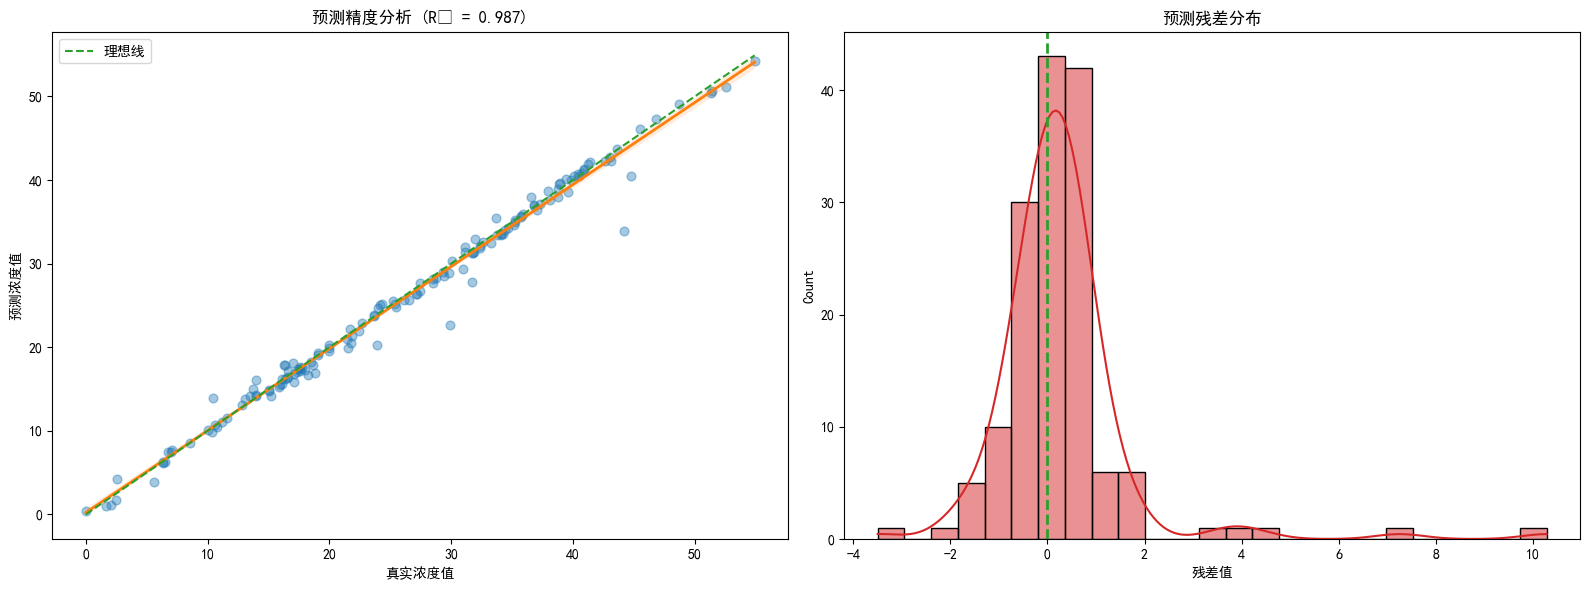

,MAE,RMSE,R²
0,0.752,1.393,0.987


In [16]:
#7、模型性能评估
def model_evaluation():
    """多维度模型评估"""
    y_pred = mlp.predict(scaler.transform(X_test))
    
    # 计算指标
    metrics = {
        'MAE': mean_absolute_error(y_test, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'R²': r2_score(y_test, y_pred)
    }
    
    # 可视化分析
    fig = plt.figure(figsize=(16,6))
    gs = fig.add_gridspec(1, 2)
    
    # 散点回归图
    ax1 = fig.add_subplot(gs[0])
    sns.regplot(x=y_test, y=y_pred, ax=ax1, 
                scatter_kws={'alpha':0.4, 's':40, 'color':'#1f77b4'},
                line_kws={'color':'#ff7f0e', 'lw':2})
    ax1.plot([y_test.min(), y_test.max()], 
            [y_test.min(), y_test.max()], 
            '--', color='#2ca02c', label='理想线')
    ax1.set_title(f"预测精度分析 (R² = {metrics['R²']:.3f})")
    ax1.set_xlabel("真实浓度值")
    ax1.set_ylabel("预测浓度值")
    ax1.legend()
    
    # 残差分布图
    ax2 = fig.add_subplot(gs[1])
    residuals = y_test - y_pred
    sns.histplot(residuals, ax=ax2, kde=True, 
                color='#d62728', bins=25)
    ax2.axvline(0, color='#2ca02c', ls='--', lw=2)
    ax2.set_title("预测残差分布")
    ax2.set_xlabel("残差值")
    
    plt.tight_layout()
    plt.show()
    
    # 指标表格
    display(pd.DataFrame([metrics]).style\
           .format(precision=3)\
           .set_caption("模型性能指标"))
    
    return y_pred

# 执行评估
test_pred = model_evaluation()

In [17]:
#8、全量预测与保存

# %% [code]
def generate_predictions():
    """生成最终预测结果"""
    print("▣ 进行全量预测...")
    X_all = scaler.transform(full_df[config["features"]])
    full_df['预测浓度'] = mlp.predict(X_all)
    
    # 保存结果
    full_df.to_excel(config["pred_save_path"], index=False)
    print(f"✓ 预测结果已保存至: {config['pred_save_path']}")
    
    # 展示样例
    return full_df[config["features"] + [config["target"], '预测浓度']].sample(5)

# 执行预测
display(generate_predictions())


▣ 进行全量预测...


NameError: name 'full_df' is not defined

In [ ]:
# 9、PID动态控制仿真

# %% [code]
def run_pid_simulation():
    """带权重分配的动态控制"""
    # 初始化参数
    pid = EnhancedPID(config["control_config"])
    variables = {
        '进气流量': 950,
        '进液流量': 18,
        '泵频': 30
    }
    
    # 记录日志
    log = []
    print("▣ 启动PID控制循环...")
    
    for step in range(200):
        # 生成当前输入
        current_input = pd.DataFrame([variables])
        scaled_input = scaler.transform(current_input)
        
        # 神经网络预测
        current_h2s = mlp.predict(scaled_input)[0]
        
        # PID计算
        adjustment = pid.update(current_h2s)
        
        # 应用加权调整
        for var in variables:
            delta = adjustment * 0.1 * config["control_config"]['weights'][var]
            variables[var] += delta
            # 参数限幅
            variables[var] = np.clip(variables[var], 
                                    full_df[var].min(), 
                                    full_df[var].max())
        
        # 记录状态
        log.append({
            '时间步': step,
            '当前浓度': current_h2s,
            ​**​variables,
            '调整量': adjustment
        })
        
        # 终止条件
        if abs(current_h2s - config["control_config"]['target']) < 0.1:
            print(f"✓ 目标达成于第 {step} 步")
            break
    
    # 保存日志
    log_df = pd.DataFrame(log)
    log_df.to_excel(config["control_log_path"], index=False)
    
    # 控制过程可视化
    plt.figure(figsize=(14, 10))
    
    # 浓度控制曲线
    plt.subplot(3, 1, 1)
    plt.plot(log_df['时间步'], log_df['当前浓度'], label='实时浓度')
    plt.axhline(config["control_config"]['target'], color='r', ls='--', label='目标值')
    plt.title("H2S浓度控制过程")
    plt.ylabel("浓度 (mg/m³)")
    plt.legend()
    
    # 控制参数变化
    plt.subplot(3, 1, 2)
    params = config["features"]
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    for i, param in enumerate(params):
        plt.plot(log_df['时间步'], log_df[param], 
                color=colors[i], label=param)
    plt.title("工艺参数调整轨迹")
    plt.ylabel("参数值")
    plt.legend()
    
    # 控制动作变化
    plt.subplot(3, 1, 3)
    plt.stem(log_df['时间步'], log_df['调整量'], 
            linefmt='#d62728', markerfmt=' ')
    plt.axhline(0, color='k', lw=0.5)
    plt.title("控制器输出变化")
    plt.xlabel("时间步")
    plt.ylabel("调整量")
    
    plt.tight_layout()
    plt.show()
    
    return log_df

# 执行仿真
control_log = run_pid_simulation()